In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rqfactor
import talib
from rqalpha.apis import *
from rqfactor.notebook.exposure import factor_analysis
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from functools import wraps
warnings.filterwarnings("ignore")
rqdatac.init()

In [30]:
df_etf = pd.read_excel('../../ETF0-ML/etf标的.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [str(code) for code in etf_code]
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_code)]

In [32]:
symbol = df_etf.order_book_id.values.tolist()
start = "2019-01-01"
end = "2023-12-31"
frequency = "1d"

In [33]:
df_price_entry = get_price(symbol, start, end, frequency)[['close']].unstack(level = 0)
df_price_entry.columns = df_price_entry.columns.droplevel(0)
frequency_h = '60m'
df_price_exit = get_price(symbol, start, end, frequency_h)[['close']].unstack(level = 0)
df_price_exit.columns = df_price_exit.columns.droplevel(0)

In [31]:
etf_1 = ['512010','159507','159825','159611','512170','159928','512980','512660','512800','512880']
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_1)]
etf_1 = df_etf.order_book_id.values.tolist()
etf_2 = [item for item in symbol if item not in etf_1]

In [32]:
df_price_entry = get_price(etf_1, start, end, frequency)[['close']].unstack(level = 0)
df_price_entry.columns = df_price_entry.columns.droplevel(0)
frequency_h = '60m'
df_price_exit = get_price(etf_1, start, end, frequency_h)[['close']].unstack(level = 0)
df_price_exit.columns = df_price_exit.columns.droplevel(0)

<Axes: xlabel='date'>

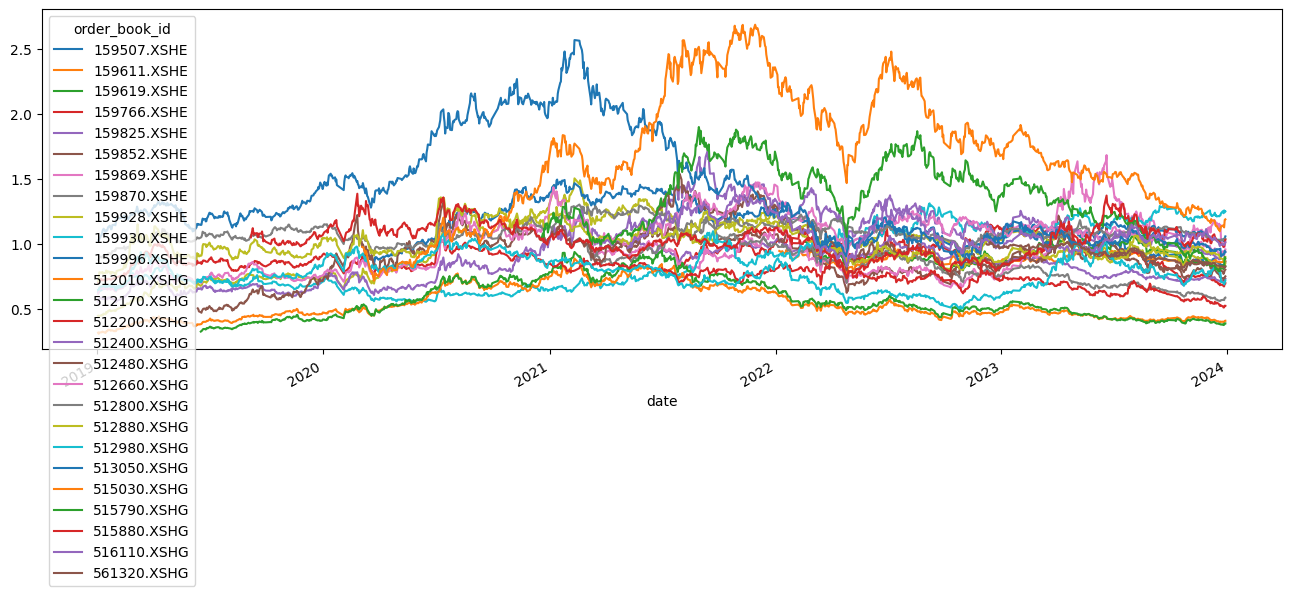

In [5]:
df_price_entry.plot(figsize=(16,5))

{}
{'512010.XSHG': 0.014914903696893415, '512200.XSHG': 0.009313897772557915, '512400.XSHG': 0.006686534880005122, '512880.XSHG': 0.010906486181504462, '512980.XSHG': 0.012020596901005208}
2019-01-14 00:00:00: 买入 512400.XSHG, 价格 0.578, 数量 8600
2019-01-14 00:00:00: 买入 512200.XSHG, 价格 0.7190000000000001, 数量 6900
{'512660.XSHG': 0.009858414031907068, '512880.XSHG': 0.011147533664404186}
{'512010.XSHG': 0.011661700964440917, '512400.XSHG': 0.0025847550304531628}
2019-01-29 10:30:00: 卖出 512400.XSHG, 价格 0.56, 数量 8600
{}
2019-02-15 15:00:00: 卖出 512200.XSHG, 价格 0.76, 数量 6900
{'512800.XSHG': 0.0180178720179313, '513050.XSHG': 0.014906938291316126}
2019-02-18 00:00:00: 买入 513050.XSHG, 价格 1.208, 数量 4100
2019-02-18 00:00:00: 买入 512800.XSHG, 价格 0.977, 数量 5200
{}
2019-02-26 11:30:00: 卖出 512800.XSHG, 价格 1.034, 数量 5200
{'159930.XSHE': 0.01646203547560724}
2019-03-04 00:00:00: 买入 159930.XSHE, 价格 0.7509999999999999, 数量 7200
2019-03-07 10:30:00: 卖出 513050.XSHG, 价格 1.276, 数量 4100
{'159928.XSHE': 0.0241989

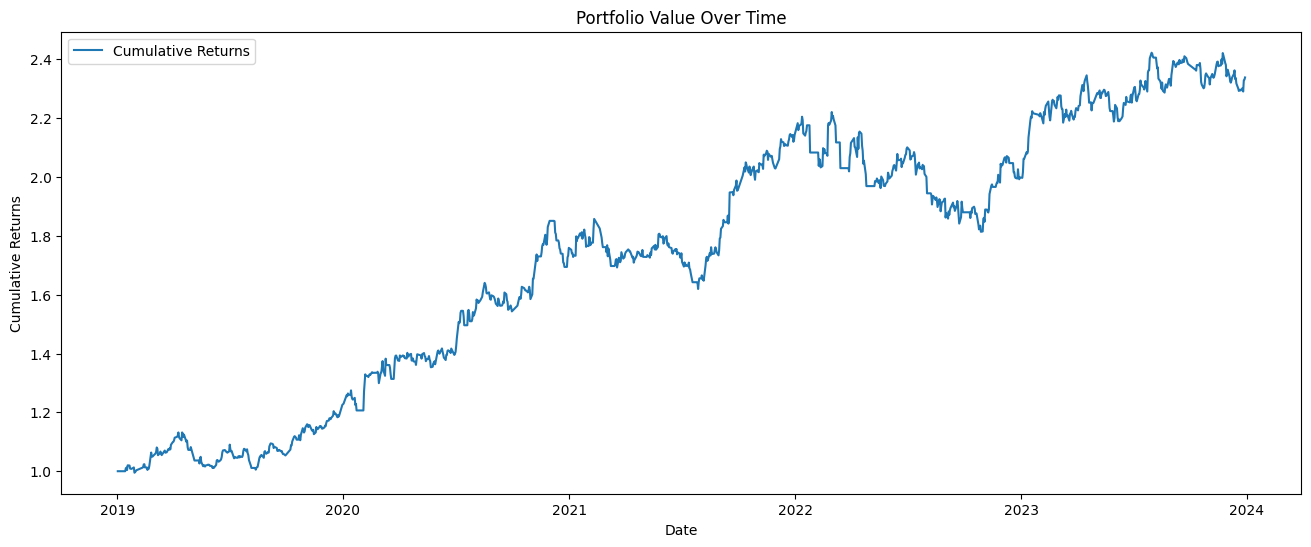

初始资金: 10000
最终资金: 23382.22
年化收益率: 19.11%
最大回撤: -18.32%
未考虑无风险利率的夏普比率: 1.21
交易次数: 280


In [35]:
initial_capital = 10000
positions = 2
slippage_and_fees = 0.00
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital
etf_value = 0
holdings = {}
peak = {}
stop_loss_point = {}
take_profit_point = {}
entry_price = {}
trade_records = []

def calculate_slope(price_data):
    price_data = price_data.replace([np.inf, -np.inf], np.nan).dropna()
    if len(price_data) < 2:
        return np.nan
    return np.polyfit(range(len(price_data)), price_data, 1)[0]

def check_buy_signals(df, date):
    etf_volatilities = {}
    etf_slopes = {}
    for etf in df.columns:
        price_data = df[etf].loc[:date].iloc[-5:]
        if price_data.count() < 5:
            continue
        volatility = price_data.pct_change().std()
        slope = calculate_slope(price_data)
        etf_volatilities[etf] = volatility
        etf_slopes[etf] = slope

    etfs_with_positive_slope = {etf: returns for etf, returns in etf_volatilities.items() if etf_slopes[etf] < 0}
    selected_etfs = sorted(etfs_with_positive_slope, key=etfs_with_positive_slope.get)[:2]
    print(etfs_with_positive_slope)
    return selected_etfs

def buy(etf, price, date):
    global capital, cash, etf_value, holdings, count
    if not np.isnan(price) and holdings.get(etf, 0) == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        if num_held_etfs < positions:
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price) // 100 * 100
            holdings[etf] = etf_amount
            cash -= etf_amount * price 
            entry_price[etf] = price 
            stop_loss_point[etf] = price * 0.97
            take_profit_point[etf] = price * 1.06
        
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count += 1

def check_stop_conditions(etf, price):
    if holdings.get(etf, 0) <= 0:
        return False
    if price < stop_loss_point.get(etf, 0):
        return True
    if price >= take_profit_point.get(etf, 0):
        stop_loss_point[etf] = take_profit_point[etf]
        take_profit_point[etf] = entry_price[etf] * (1 + 0.01 * (int((price / entry_price[etf] - 1) / 0.01) + 2))
    return False

def sell(etf, price, date):
    global capital, cash, etf_value, holdings, count
    if not np.isnan(price) and holdings.get(etf, 0) > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
        count += 1

start_date = pd.to_datetime('2014-01-02')
last_rebalance_date = start_date
trading_hours = ['10:30', '11:30', '14:00', '15:00']
count = 0

for date, prices_daily in df_price_entry.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    # 检查是否到了每周的调仓日（周一）且自上次买入以来至少过去了一周
    if date.weekday() == 0 and date > last_rebalance_date:
        selected_etfs = check_buy_signals(df_price_entry, date)
        for etf in selected_etfs:
            if etf in prices_daily and not np.isnan(prices_daily[etf]):
                buy(etf, prices_daily[etf], date)
        last_buy_date = date  # 更新上次买入日期
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]
            for etf in holdings.keys():  # 遍历当前持有的ETF
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    
    etf_value = sum(holdings.get(etf, 0) * prices_daily.get(etf, 0) for etf in holdings if holdings.get(etf, 0) > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev

plt.figure(figsize=(16, 6))
plt.plot(df_price_entry.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")

{}
{'512010.XSHG': 0.014914903696893415, '512200.XSHG': 0.009313897772557915, '512400.XSHG': 0.006686534880005122, '512880.XSHG': 0.010906486181504462, '512980.XSHG': 0.012020596901005208}
2019-01-14 00:00:00: 买入 512400.XSHG, 价格 0.578, 数量 8600
2019-01-14 00:00:00: 买入 512200.XSHG, 价格 0.7190000000000001, 数量 6900
{'512660.XSHG': 0.009858414031907068, '512880.XSHG': 0.011147533664404186}
{'512010.XSHG': 0.011661700964440917, '512400.XSHG': 0.0025847550304531628}
2019-01-29 10:30:00: 卖出 512400.XSHG, 价格 0.56, 数量 8600
{}
2019-02-15 15:00:00: 卖出 512200.XSHG, 价格 0.76, 数量 6900
{'512800.XSHG': 0.0180178720179313, '513050.XSHG': 0.014906938291316126}
2019-02-18 00:00:00: 买入 513050.XSHG, 价格 1.208, 数量 4100
2019-02-18 00:00:00: 买入 512800.XSHG, 价格 0.977, 数量 5200
{}
2019-02-26 11:30:00: 卖出 512800.XSHG, 价格 1.034, 数量 5200
{'159930.XSHE': 0.01646203547560724}
2019-03-04 00:00:00: 买入 159930.XSHE, 价格 0.7509999999999999, 数量 7200
2019-03-07 10:30:00: 卖出 513050.XSHG, 价格 1.276, 数量 4100
{'159928.XSHE': 0.0241989

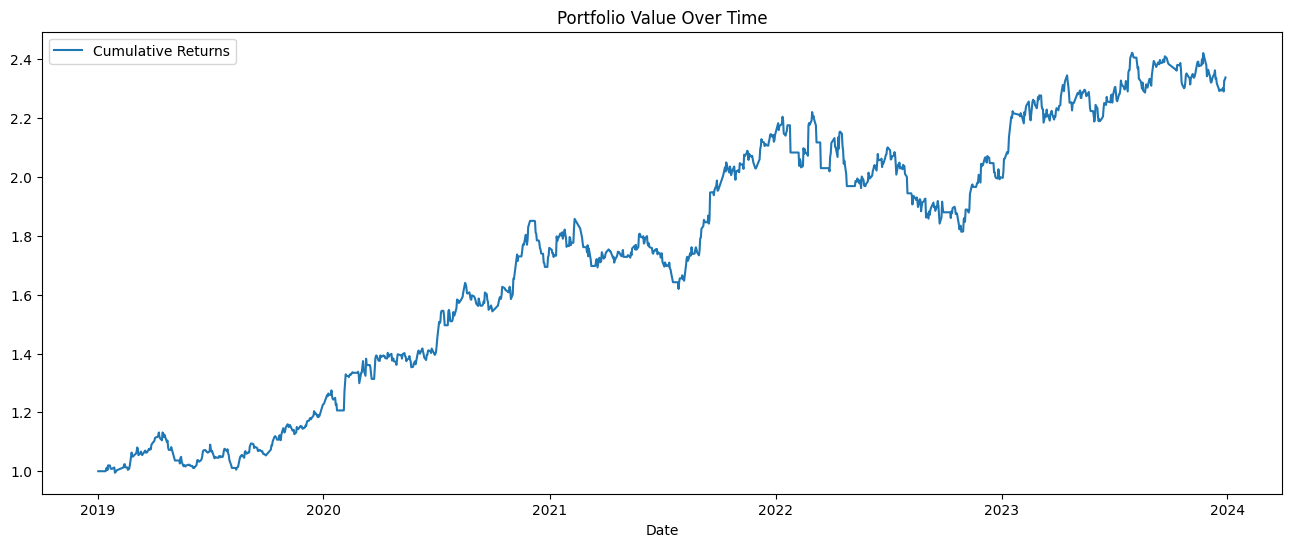

初始资金: 10000
最终资金: 23382.22
年化收益率: 19.11%
最大回撤: -18.32%
未考虑无风险利率的夏普比率: 1.21
交易次数: 280


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

initial_capital = 10000
positions = 2
slippage_and_fees = 0.00
portfolio_value_tracker = []
trade_records = []

capital = initial_capital
cash = initial_capital
etf_value = 0
holdings = {}
peak = {}
stop_loss_point = {}
take_profit_point = {}
entry_price = {}

def calculate_slope(price_data):
    price_data = price_data.replace([np.inf, -np.inf], np.nan).dropna()
    if len(price_data) < 2:
        return np.nan
    return np.polyfit(range(len(price_data)), price_data, 1)[0]

def check_buy_signals(df, date):
    etf_volatilities = {}
    etf_slopes = {}
    for etf in df.columns:
        price_data = df[etf].loc[:date].iloc[-5:]
        if price_data.count() < 5:
            continue
        volatility = price_data.pct_change().std()
        slope = calculate_slope(price_data)
        etf_volatilities[etf] = volatility
        etf_slopes[etf] = slope

    etfs_with_positive_slope = {etf: returns for etf, returns in etf_volatilities.items() if etf_slopes[etf] < 0}
    selected_etfs = sorted(etfs_with_positive_slope, key=etfs_with_positive_slope.get)[:2]
    print(etfs_with_positive_slope)
    return selected_etfs

def buy(etf, price, date):
    global capital, cash, etf_value, holdings, count, trade_records
    if not np.isnan(price) and holdings.get(etf, {}).get('amount', 0) == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h.get('amount', 0) > 0)
        if num_held_etfs < positions:
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price) // 100 * 100
            trade_record = {'ETF': etf, 'Buy Date': date, 'Buy Price': price, 'Sell Date': None, 'Profit/Loss': None}
            holdings[etf] = {'amount': etf_amount, 'trade_record': trade_record}
            cash -= etf_amount * price 
            entry_price[etf] = price 
            stop_loss_point[etf] = price * 0.97
            take_profit_point[etf] = price * 1.06
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count += 1

def check_stop_conditions(etf, price):
    if holdings.get(etf, {}).get('amount', 0) <= 0:
        return False
    if price < stop_loss_point.get(etf, 0):
        return True
    if price >= take_profit_point.get(etf, 0):
        stop_loss_point[etf] = take_profit_point[etf]
        take_profit_point[etf] = entry_price[etf] * (1 + 0.01 * (int((price / entry_price[etf] - 1) / 0.01) + 2))
    return False

def sell(etf, price, date):
    global capital, cash, etf_value, holdings, count, trade_records
    if not np.isnan(price) and holdings.get(etf, {}).get('amount', 0) > 0:
        etf_amount = holdings[etf]['amount']
        trade_record = holdings[etf]['trade_record']
        proceeds = etf_amount * price * (1 - slippage_and_fees)
        profit_loss = proceeds - trade_record['Buy Price'] * etf_amount
        cash += proceeds 
        etf_value -= etf_amount * price
        trade_record.update({"Sell price": price ,'Sell Date': date, 'Profit/Loss': profit_loss})
        trade_records.append(trade_record)
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {etf_amount}")
        holdings[etf] = {'amount': 0, 'trade_record': None}
        count += 1

start_date = pd.to_datetime('2014-01-02')
last_rebalance_date = start_date
trading_hours = ['10:30', '11:30', '14:00', '15:00']
count = 0

for date, prices_daily in df_price_entry.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    if date.weekday() == 0 and date > last_rebalance_date:
        selected_etfs = check_buy_signals(df_price_entry, date)
        for etf in selected_etfs:
            if etf in prices_daily and not np.isnan(prices_daily[etf]):
                buy(etf, prices_daily[etf], date)
        last_buy_date = date
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]
            for etf in holdings.keys():
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    etf_value = sum(holdings.get(etf, {}).get('amount', 0) * prices_daily.get(etf, 0) for etf in holdings if holdings.get(etf, {}).get('amount', 0) > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev

plt.figure(figsize=(16, 6))
plt.plot(df_price_entry.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()


print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")

In [50]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

trade_records_df = pd.DataFrame(trade_records)
trade_records_df

,ETF,Buy Date,Buy Price,Sell Date,Profit/Loss,Sell price
0,512400.XSHG,2019-01-14,0.5780,2019-01-29 10:30:00,-154.80,0.5600
1,512200.XSHG,2019-01-14,0.7190,2019-02-15 15:00:00,282.90,0.7600
2,512800.XSHG,2019-02-18,0.9770,2019-02-26 11:30:00,296.40,1.0340
3,513050.XSHG,2019-02-18,1.2080,2019-03-07 10:30:00,278.80,1.2760
4,159930.XSHE,2019-03-04,0.7510,2019-03-14 15:00:00,-165.60,0.7280
5,512660.XSHG,2019-03-18,0.7970,2019-03-25 15:00:00,290.40,0.8410
6,512800.XSHG,2019-03-11,1.0250,2019-04-09 10:30:00,290.70,1.0820
7,512400.XSHG,2019-04-15,0.7100,2019-04-25 15:00:00,-207.90,0.6830
8,512010.XSHG,2019-04-08,0.4295,2019-04-26 10:30:00,-185.90,0.4152
9,512200.XSHG,2019-04-29,0.8980,2019-05-06 10:30:00,-171.10,0.8690


In [59]:
print("交易亏损占比:",trade_records_df[trade_records_df['Profit/Loss'] < 0].shape[0]/ trade_records_df.shape[0])
print("交易盈利占比:",trade_records_df[trade_records_df['Profit/Loss'] > 0].shape[0]/ trade_records_df.shape[0])

交易亏损占比: 0.5323741007194245
交易盈利占比: 0.4676258992805755


In [61]:
len(trade_records_df.ETF.unique())

24

In [ ]:
"512400.XSHG"

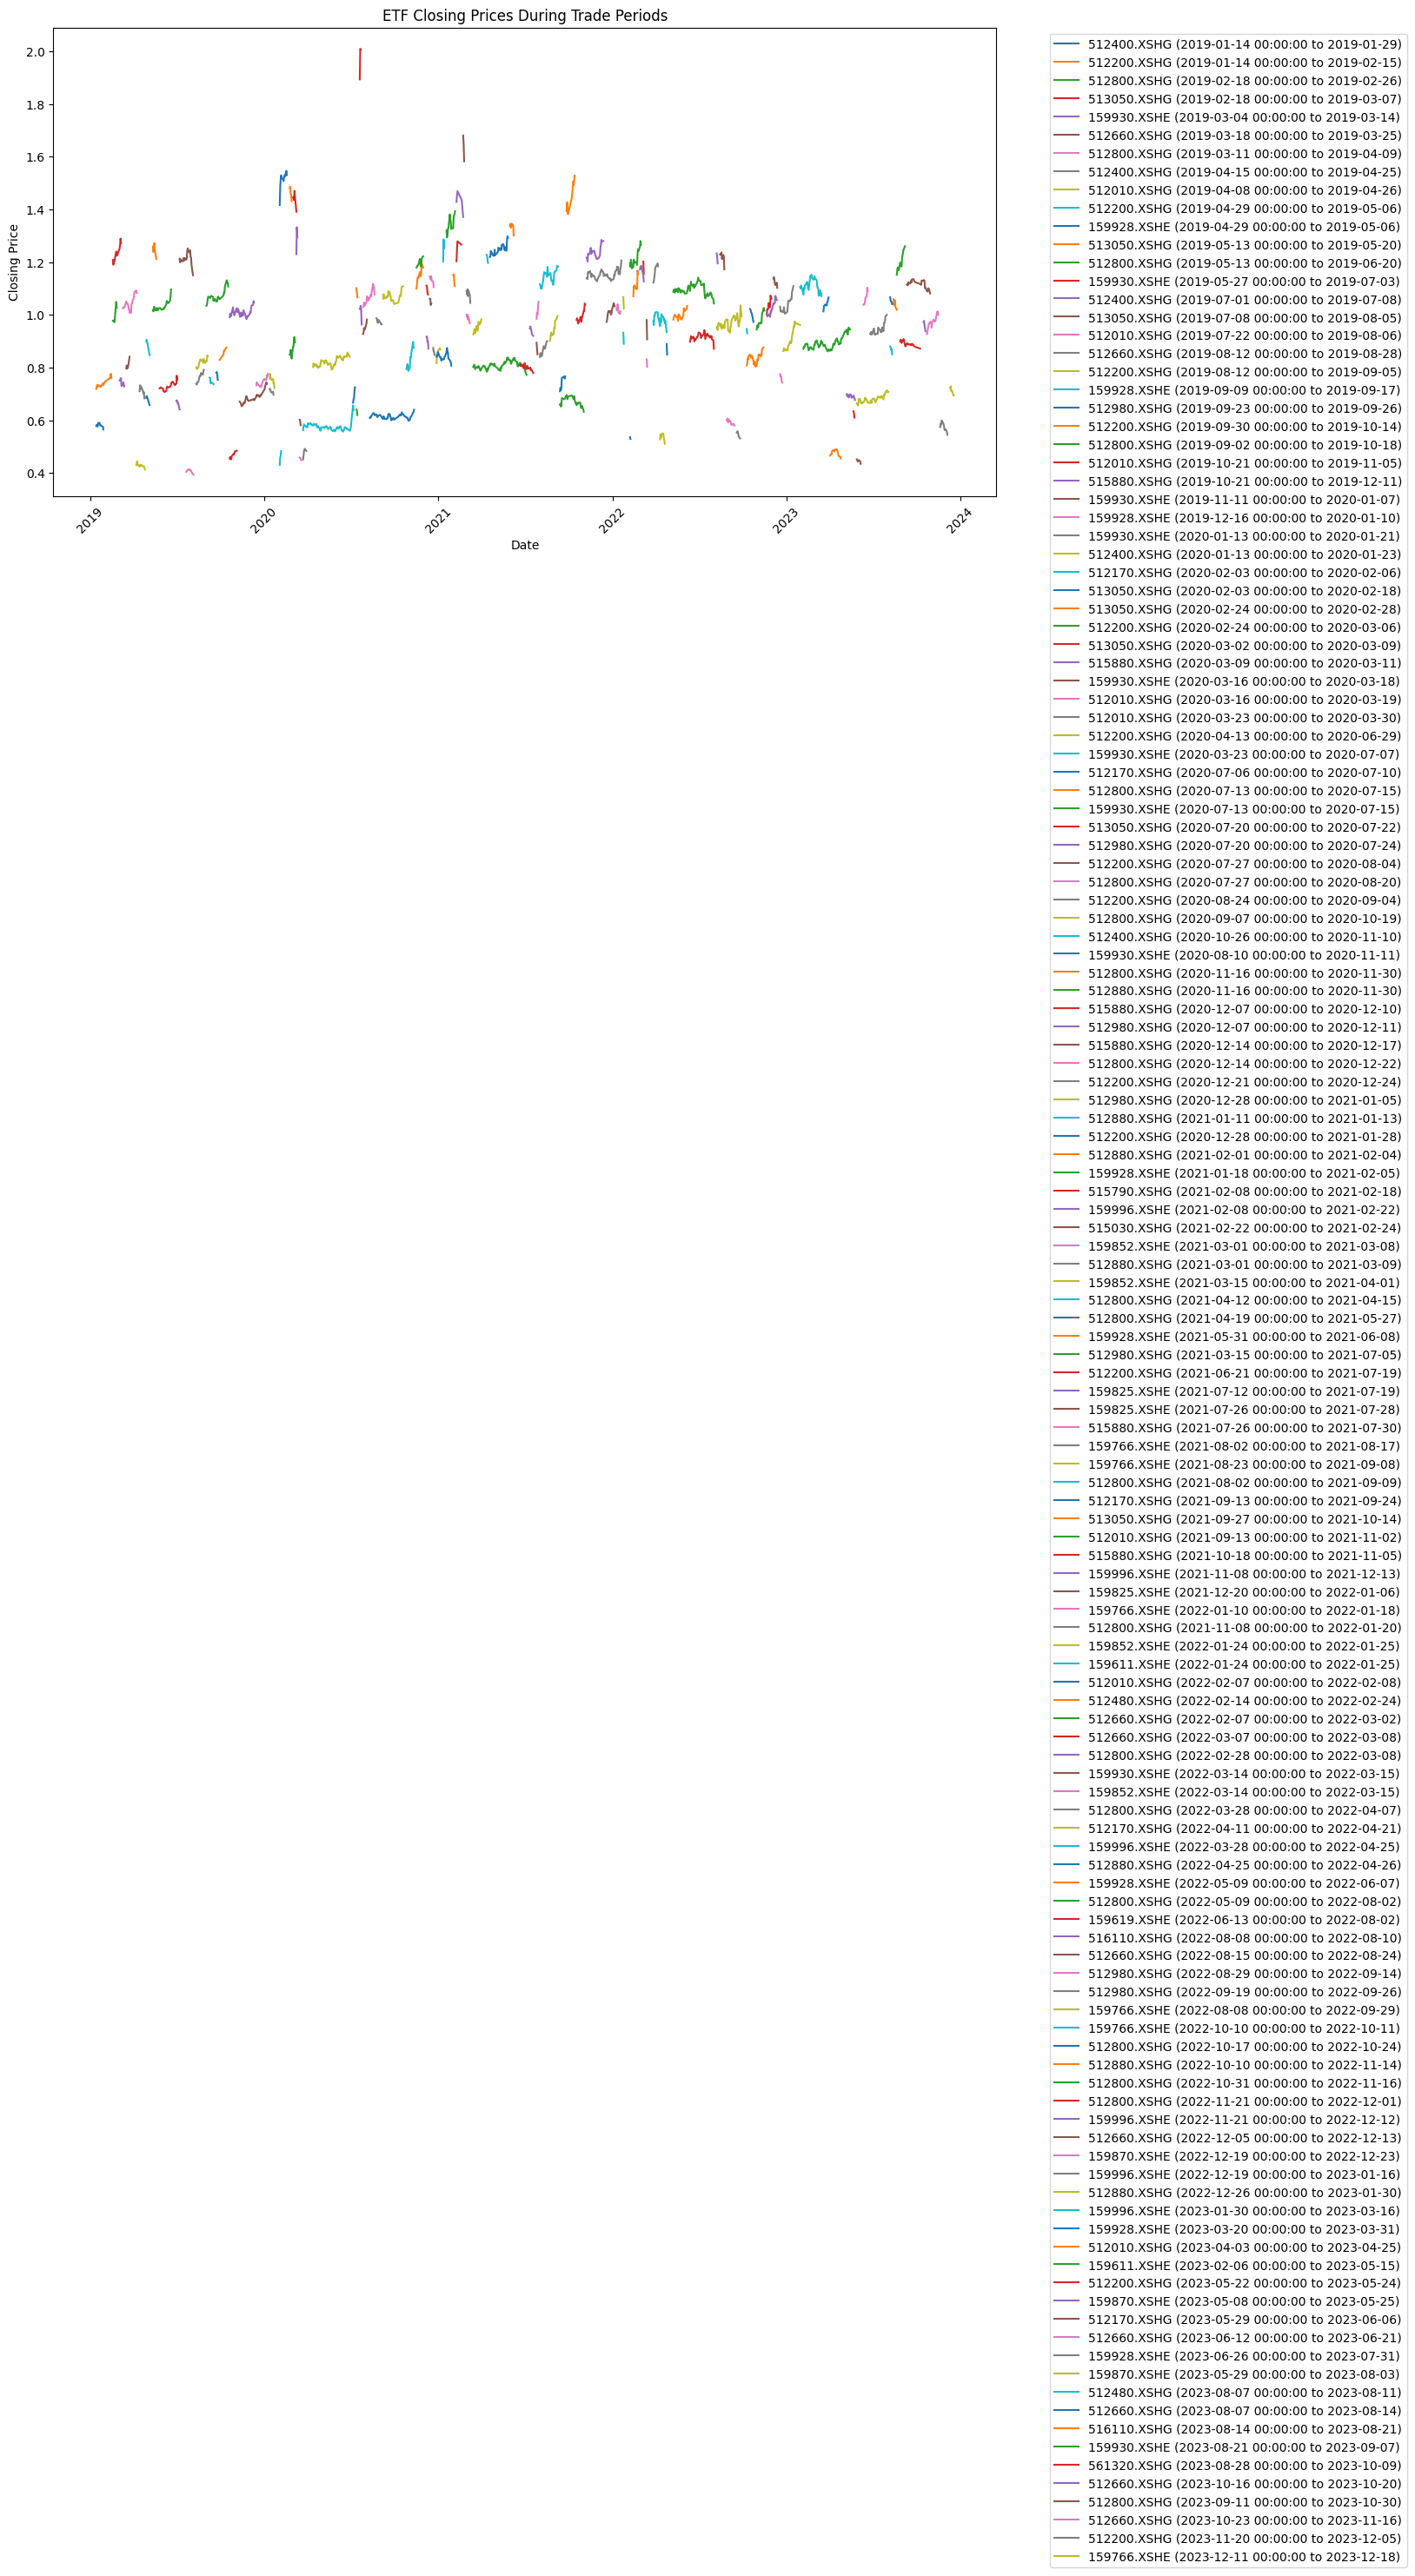

In [83]:
plt.figure(figsize=(14, 7))

# 遍历交易记录
for index, row in trade_records_df.iterrows():
    etf_name = row['ETF']
    # buy_date = row['Buy Date'] - datetime.timedelta(20)

    buy_date = row['Buy Date']
    sell_date = pd.to_datetime(row['Sell Date']).strftime('%Y-%m-%d')
    time_period = df_price_entry[etf_name][buy_date:sell_date]
    plt.plot(time_period.index, time_period.values, label=f"{etf_name} ({buy_date} to {sell_date})")
    
plt.title('ETF Closing Prices During Trade Periods')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
date = '2023-04-25 14:00:00'
pd.to_datetime(date).strftime('%Y-%m-%d')

'2023-04-25'

In [6]:
n1 = portfolio_values

In [7]:
symbol = '510300.XSHG'
start = "2019-01-01"
end = "2023-12-31"
frequency = "1d"
df_price_am = get_price(symbol, start, end, frequency)[['close']]
df_price_am['close'] = df_price_am['close']/df_price_am['close'][0]

In [8]:
n2 = df_price_am['close']

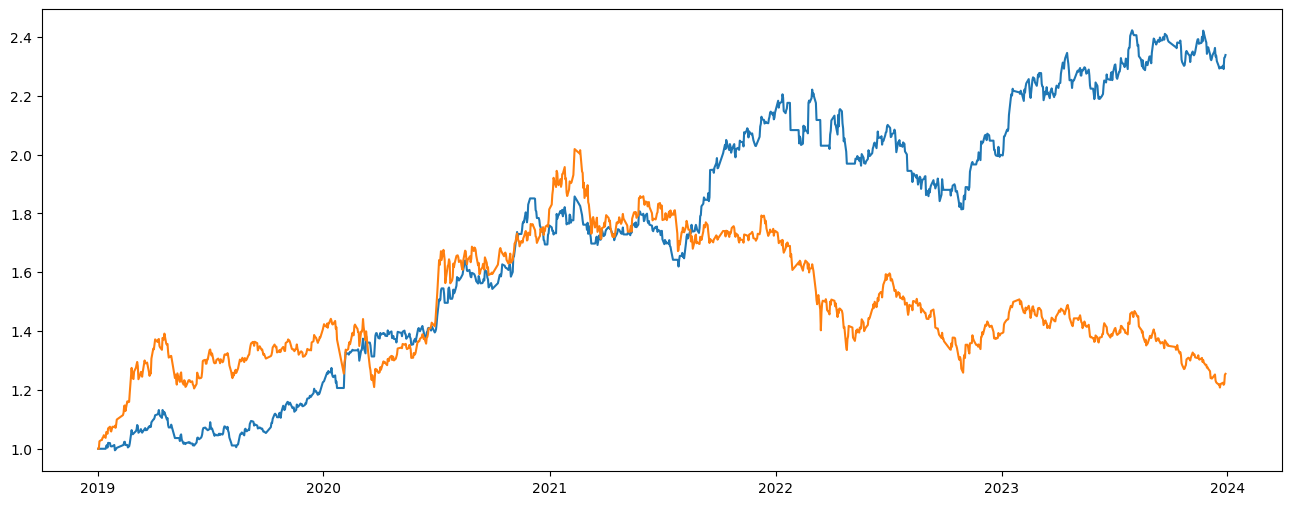

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df_price_entry.index, n1/10000, label='ETF')
plt.plot(df_price_entry.index, n2, label='HS300')

In [25]:
df = get_price(symbol, start, end, frequency)[['open','high','low','close']]
df['previous_close'] = df.groupby(level=0)['close'].shift(1)
df['tr0'] = df['high'] - df['low']
df['tr1'] = (df['high'] - df['previous_close']).abs()
df['tr2'] = (df['low'] - df['previous_close']).abs()
df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
df_atr = df.groupby(level=0)['tr'].rolling(window=14).mean().droplevel(0)
df_atr = df_atr.unstack(level=0)

2014-07-18 00:00:00: 买入 512010.XSHG, 价格 0.21, 数量 23800
2014-08-01 15:00:00: 卖出 512010.XSHG, 价格 0.2225, 数量 23800
2014-10-31 00:00:00: 买入 159930.XSHE, 价格 0.9, 数量 5700
2014-11-14 00:00:00: 买入 159928.XSHE, 价格 0.2598, 数量 19800
2014-12-01 11:30:00: 卖出 159930.XSHE, 价格 0.954, 数量 5700
2014-12-03 14:00:00: 卖出 159928.XSHE, 价格 0.2752, 数量 19800
2015-06-30 00:00:00: 买入 159930.XSHE, 价格 1.399, 数量 3800
2015-07-01 15:00:00: 卖出 159930.XSHE, 价格 1.351, 数量 3800
2016-01-08 00:00:00: 买入 512010.XSHG, 价格 0.32, 数量 16700
2016-01-11 11:30:00: 卖出 512010.XSHG, 价格 0.3032, 数量 16700
2016-04-28 00:00:00: 买入 512010.XSHG, 价格 0.2795, 数量 18600
2016-07-12 11:30:00: 卖出 512010.XSHG, 价格 0.3038, 数量 18600
2016-09-23 00:00:00: 买入 159930.XSHE, 价格 0.795, 数量 6800
2016-11-14 14:00:00: 卖出 159930.XSHE, 价格 0.849, 数量 6800
2016-12-19 00:00:00: 买入 512010.XSHG, 价格 0.3348, 数量 16800
2016-12-20 10:30:00: 卖出 512010.XSHG, 价格 0.318, 数量 16800
2016-12-21 00:00:00: 买入 159928.XSHE, 价格 0.3645, 数量 15000
2016-12-22 00:00:00: 买入 512010.XSHG, 价格 0.3275, 数量

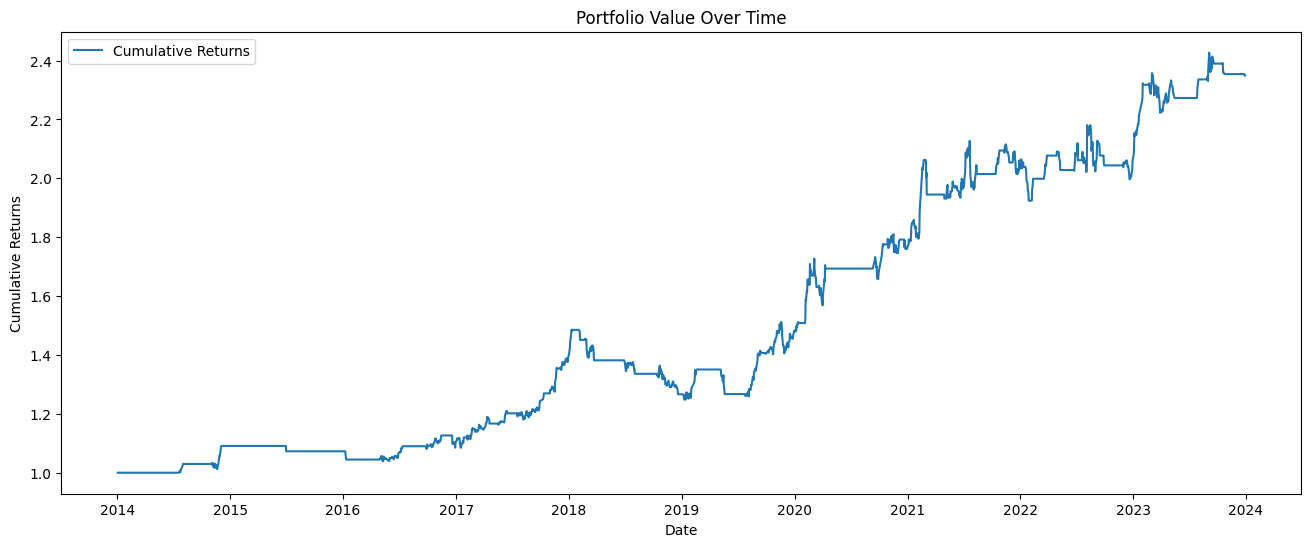

初始资金: 10000
最终资金: 23488.03
年化收益率: 9.17%
最大回撤: -16.01%
未考虑无风险利率的夏普比率: 0.98
交易次数: 209


In [27]:
df = df_price_entry
count = 0
initial_capital = 10000
positions = 2
slippage_and_fees = 0.00  # 滑点
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}
# 初始止损位和止盈位
stop_loss_point = {etf: 0 for etf in df.columns}
take_profit_point = {etf: 0 for etf in df.columns}
entry_price = {etf: 0 for etf in df.columns}

# 突破60日均线 + 斜率
def check_buy_signals(etf, price_data_daily, current_date, start_date, df_atr, atr_threshold=0.0):
    if len(price_data_daily) < 60 or current_date < start_date + pd.Timedelta(days=60):
        return False
    ma50 = price_data_daily[-60:].mean()
    yesterday_close = price_data_daily[-2]
    today_close = price_data_daily[-1]
    slope_positive = np.polyfit(range(60), price_data_daily[-60:], 1)[0] > 0
    current_atr = df_atr.loc[current_date, etf]
    atr_ma60 = df_atr[etf].rolling(window=10).mean().loc[current_date]
    if yesterday_close < ma50 and today_close >= ma50 and slope_positive and current_atr > atr_ma60 * atr_threshold:
        return True
    return False


def buy(etf, price, date):
    global capital, cash, etf_value, holdings, count
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        if num_held_etfs < positions:
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price) // 100 * 100
            holdings[etf] = etf_amount
            cash -= etf_amount * price 
            entry_price[etf] = price 
            stop_loss_point[etf] = price * 0.97
            take_profit_point[etf] = price * 1.06
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count += 1

def check_stop_conditions(etf, price):
    global stop_loss_point, take_profit_point

    if holdings[etf] <= 0:
        return False
    if price < stop_loss_point[etf]:
        return True

    if price >= take_profit_point[etf]:
        stop_loss_point[etf] = take_profit_point[etf]
        take_profit_point[etf] = entry_price[etf] * (1 + 0.01 * (int((price / entry_price[etf] - 1) / 0.01) + 1))
    return False

def sell(etf, price, date):
    global capital, cash, etf_value, holdings,count
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
        count+=1

start_date = pd.to_datetime('2014-01-02')
# 主循环 循环df_price_entry和df_price_exit
trading_hours = ['10:30', '11:30', '14:00', '15:00']
for date, prices_daily in df.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]

            # 循环 df_price_exit小时线数据找准时机出场
            for etf in prices_daily.index:
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    
    # 循环 df_price_entry 日线数据卖出
    for etf in prices_daily.index:
        price_data_daily = df[etf].loc[:date]
        if check_buy_signals(etf, price_data_daily, date, start_date, df_atr, atr_threshold=1.0):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices_daily[etf], date)
    etf_value = sum(holdings[etf] * prices_daily[etf] for etf in prices_daily.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")

In [9]:
n2 = portfolio_values

In [11]:
portfolio_values = (n1 + n2)/2

In [12]:
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev
print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")

初始资金: 10000
最终资金: 20395.485
年化收益率: 15.81%
最大回撤: -10.44%
未考虑无风险利率的夏普比率: 1.39


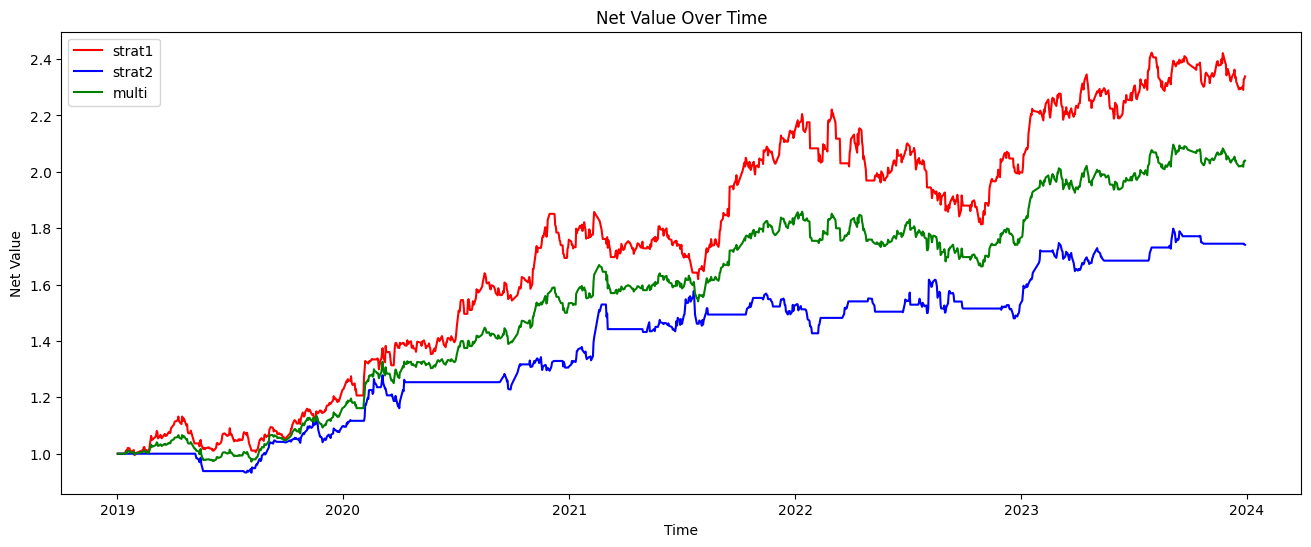

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, n1/10000, label='strat1', color='red')
plt.plot(df.index, n2/10000, label='strat2', color='blue')
plt.plot(df.index, portfolio_values/10000, label='multi', color='green')
plt.legend()
plt.title('Net Value Over Time')
plt.xlabel('Time')
plt.ylabel('Net Value')

plt.show()